# Searchable world map visualisation

Visualise the frequency of occurrence of different keywords in this dataset, across the world.

In [73]:
import duckdb
import geopandas as gpd
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

from data_helpers import download_data

## 1. Fetch the data and create an in-memory database

Using `duckdb`.

In [4]:
# INTERNAL NOTE: use this commit hash until the weekly pipeline run that produces the
# data is stable.
CACHE_DIR = "../cache"
download_data(
    cache_dir=CACHE_DIR,
    revision="bd0abf24ae34d3150bdd8ac66f36a28e47f3ee93",
)

Fetching 15 files: 100%|██████████| 15/15 [00:00<00:00, 5690.54it/s]


In [5]:
db = duckdb.connect()

# Authenticate (needed if loading a private dataset)
# You'll need to log in using `huggingface-cli login` in your terminal first
db.execute("CREATE SECRET hf_token (TYPE HUGGINGFACE, PROVIDER credential_chain);")

# Create a view called 'open_data', and count the number of rows and distinct documents
# in the view
db.execute(
    f"CREATE VIEW open_data AS SELECT * FROM read_parquet('{CACHE_DIR}/*.parquet')"
)
db.sql("SELECT COUNT(*), COUNT(DISTINCT document_id) FROM open_data")

┌──────────────┬─────────────────────────────┐
│ count_star() │ count(DISTINCT document_id) │
│    int64     │            int64            │
├──────────────┼─────────────────────────────┤
│     21037269 │                        7795 │
└──────────────┴─────────────────────────────┘

## 2. Create maps using keyword searches

In [85]:
def get_geography_count_for_texts(texts: list[str]) -> pd.DataFrame:
    """
    Get the number of paragraphs containing any of the given texts, grouped by geography.

    Returns dataframe with columns 'geography ISO', and 'count'.
    """

    regex = f".*({'|'.join(texts)}).*"
    results_df = db.sql(
        f"""
        SELECT "document_metadata.geographies", COUNT(*)
        FROM open_data 
        WHERE "document_metadata.languages" = ['English']
            AND ("text_block.text" SIMILAR TO '{regex}')
            AND "document_metadata.geographies" IS NOT NULL
            AND "document_metadata.geographies" <> ['XAA']
        GROUP BY "document_metadata.geographies"
        ORDER BY COUNT(*) DESC
        """
    ).to_df()

    results_df["document_metadata.geographies"] = results_df[
        "document_metadata.geographies"
    ].apply(lambda x: x[0])

    results_df = results_df.rename(
        columns={
            "document_metadata.geographies": "geography ISO",
            "count_star()": "count",
            # 'any_value("document_metadata.family_import_id")': "family ID"
        }
    )

    return results_df


get_geography_count_for_texts(
    [
        "low income",
        "low-income",
    ]
)

,geography ISO,count
0,USA,301
1,GBR,154
2,NZL,113
3,EUR,63
4,ZAF,49
...,...,...
135,SDN,1
136,CUB,1
137,ECU,1
138,FSM,1


In [86]:
def load_world_geometries():
    """
    Get world geometries in Eckert IV projection.

    Drop Antarctica and Seven seas (open ocean) geometries to make the map look nicer.
    """
    world = gpd.read_file("./ne_50m_admin_0_countries.zip")
    world = world.to_crs(
        "+proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"
    )

    world = world[~world["ADMIN"].isin(["Antarctica", "Seven seas (open ocean)"])]

    return world


world = load_world_geometries()

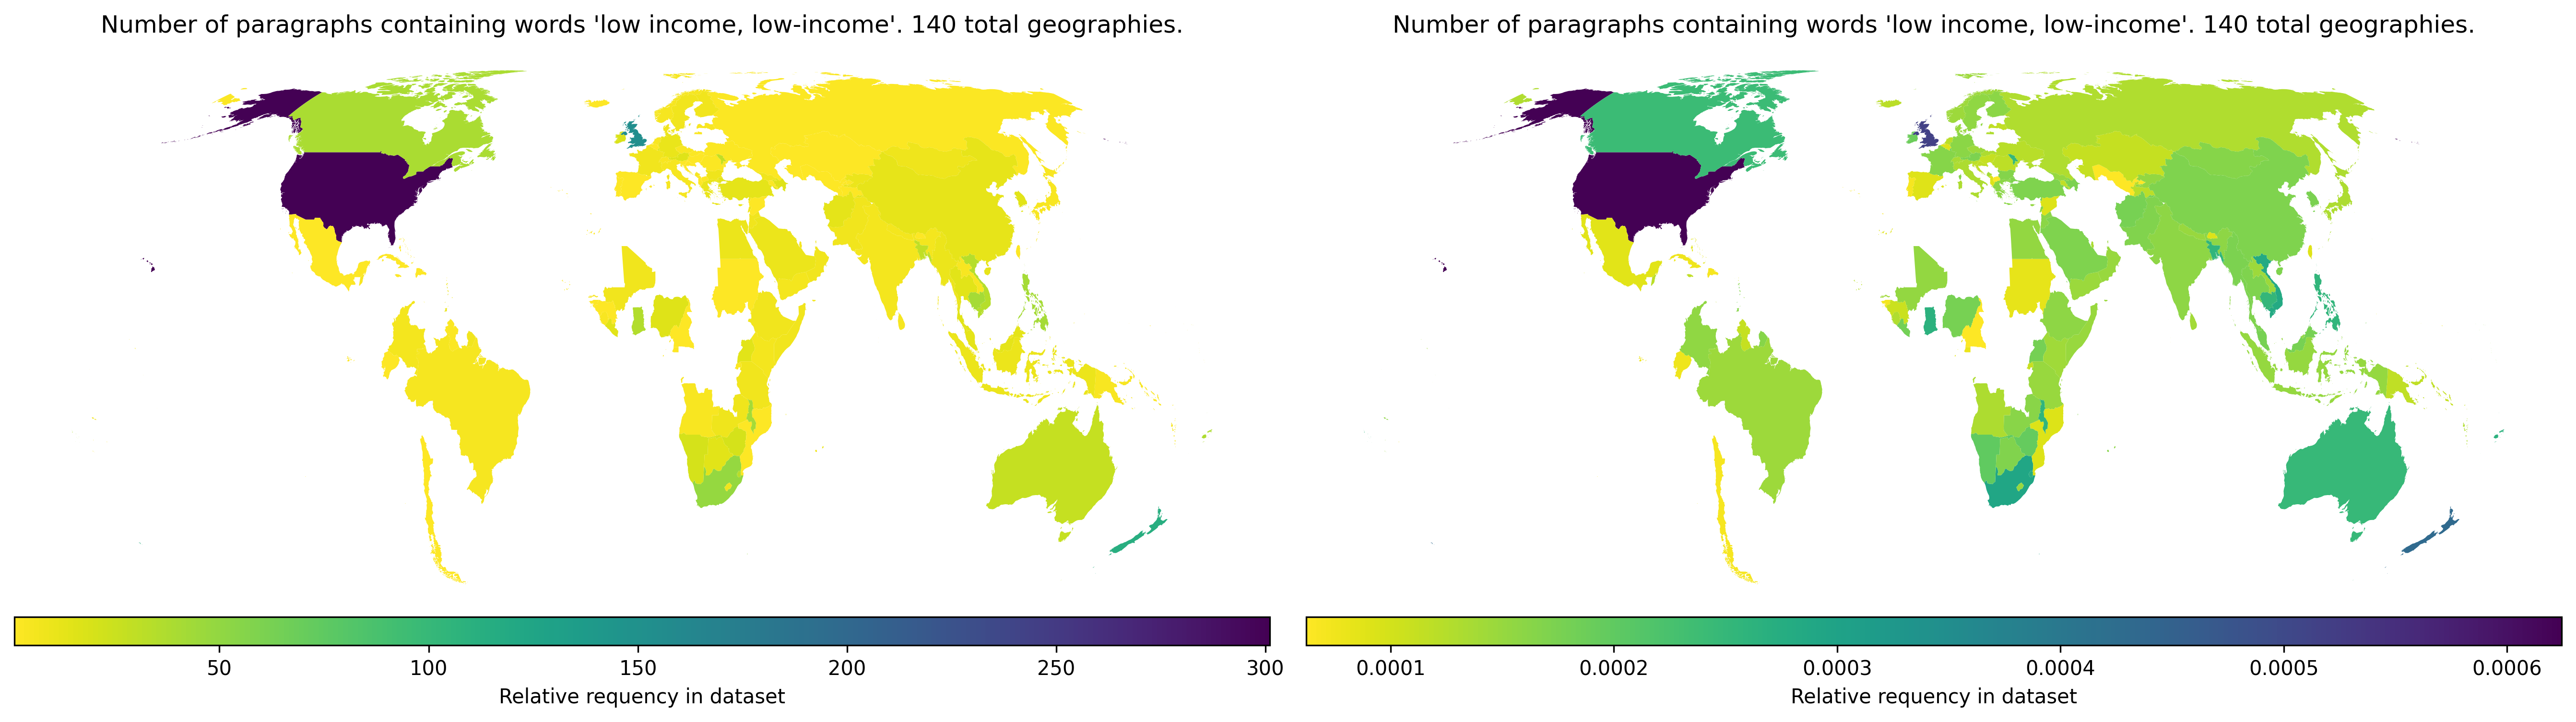

In [104]:
paragraph_count_by_geography = get_geography_count_for_texts([".*"])


def plot_country_map(
    keywords: list[str],
    legend_label: str = "Relative requency in dataset",
    normalize_counts: bool = False,
    axis=None,
):
    """
    Plot a map of the world with countries colored by the number of paragraphs containing any of the given keywords.

    Returns a GeoDataFrame with columns 'ADMIN', 'geography ISO', 'count', 'geometry'.
    """
    results_df = get_geography_count_for_texts(keywords)

    # normalise by paragraph_count_by_geography
    if normalize_counts:
        results_df["count"] = (
            results_df["count"] / paragraph_count_by_geography["count"]
        )

    min_count, max_count = results_df["count"].min(), results_df["count"].max()
    num_geographies = results_df["geography ISO"].nunique()

    # TODO: is 'ADMO_ISO' the right column to join on? The one that Anne initially
    # specified, 'ADMO_A3', doesn't exist in this dataset.
    world_with_counts = world.merge(
        results_df, left_on="ADM0_A3", right_on="geography ISO"
    )

    if axis:
        fig = axis.get_figure()
    else:
        fig, axis = plt.subplots(figsize=(18, 9), dpi=300)

    world_with_counts.plot(
        column="count",
        legend=False,
        figsize=(20, 10),
        ax=axis,
        vmin=min_count,
        vmax=max_count,
        cmap="viridis_r",
    )

    divider = make_axes_locatable(axis)
    cax = divider.append_axes("bottom", size="5%", pad=0.05)
    fig.colorbar(
        mpl.cm.ScalarMappable(
            norm=mpl.colors.Normalize(vmin=min_count, vmax=max_count), cmap="viridis_r"
        ),
        cax=cax,
        orientation="horizontal",
        label=legend_label,
    )

    sns.despine(ax=axis, top=True, bottom=True, left=True, right=True)
    axis.set_xticks([])
    axis.set_yticks([])

    # #Set markers to square shape
    # leg1 = ax.get_legend()
    # for ea in leg1.legend_handles:
    #     ea.set_marker('s')
    fig.tight_layout()

    axis.set_title(
        f"Number of paragraphs containing words '{', '.join(keywords)}'. {num_geographies} total geographies."
    )

    return fig, axis


kwds = [
    "low income",
    "low-income",
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9), dpi=300)

ax1 = plot_country_map(
    kwds,
    normalize_counts=False,
    axis=ax1,
)

ax2 = plot_country_map(
    kwds,
    normalize_counts=True,
    axis=ax2,
)